In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms

from robustness.attacks.fast_gradient import FastGradient
from robustness.attacks.projected_gradient_descent import ProjectedGradientDescent

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Define models

In [12]:
class CNN_A(nn.Module):
    def __init__(self):
        super(CNN_A, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(3*3*64, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.view(-1, 3*3*64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class CNN_B(nn.Module):
    def __init__(self):
        super(CNN_B, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3)
        self.fc1 = nn.Linear(1024, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 1024)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Define train and evaulation methods

In [13]:
def train(model, train_loader, optimizer, device, epochs):
    # Set model to training mode
    model.train()

    for epoch in range(epochs):

        running_loss = 0.
        correct = 0
        running_confidences = []

        # Loop over each batch from the training set
        for batch in train_loader:
            # Copy data to device if needed
            batch = tuple(t.to(device) for t in batch)

            # Unpack the batch from the loader
            inputs, labels = batch

            # Zero gradient buffers
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, labels)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            # Update metrics
            running_loss += loss.item() * len(inputs)
            correct += (outputs.argmax(dim=1) == labels).sum().item()

            confidence, _ = outputs.softmax(dim=1).max(dim=1)
            running_confidences += confidence
        
        metrics = {'loss': running_loss / len(train_loader.dataset),
                   'accuracy': correct / len(train_loader.dataset),
                   'average_confidence': (sum(running_confidences) / len(train_loader.dataset)).item()}

        print(metrics)

    return metrics

def evaluate(model, data_loader, device, attack=None):
    # Set model to evaluation mode
    model.eval()

    correct = 0
    running_loss = 0.
    running_confidences = []
    
    # Loop over each batch from the validation set
    for batch in data_loader:
        
        # Copy data to device if needed
        batch = tuple(t.to(device) for t in batch)

        # Unpack the batch from the loader
        inputs, labels = batch

        if attack:
            inputs, _ = attack.generate(inputs, labels)
        
        # Forward pass
        with torch.no_grad():
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, labels)

            # Update metrics
            running_loss += loss.item() * len(inputs)
            correct += (outputs.argmax(dim=1) == labels).sum().item()

            confidence, _ = outputs.softmax(dim=1).max(dim=1)
            running_confidences += confidence

    metrics = {'loss': running_loss / len(data_loader.dataset),
               'accuracy': correct / len(data_loader.dataset),
               'average_confidence': (sum(running_confidences) / len(data_loader.dataset)).item()}

    return metrics

# Prepare data

In [29]:
def prepare_mnist(batch_size):
    transform = transforms.Compose([transforms.ToTensor()])

    train_set = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
    test_set = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform)

    train_a_set, train_b_set = torch.utils.data.random_split(train_set, [30000, 30000])

    train_a_loader = torch.utils.data.DataLoader(train_a_set, batch_size=batch_size, shuffle=True, num_workers=2)
    train_b_loader = torch.utils.data.DataLoader(train_b_set, batch_size=batch_size, shuffle=True, num_workers=2)

    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=2)

    return train_a_loader, train_b_loader, test_loader

# Train and evaluate models

In [30]:
train_a_loader, train_b_loader, test_loader = prepare_mnist(batch_size=128)

{'root': '../data', 'transform': Compose(
    ToTensor()
), 'target_transform': None, 'transforms': StandardTransform
Transform: Compose(
               ToTensor()
           ), 'train': True, 'data': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
  

In [20]:
model_a = CNN_A().to(device)
model_b = CNN_B().to(device)

optimizer_a = optim.SGD(model_a.parameters(), lr=0.001, momentum=0.9)
optimizer_b = optim.SGD(model_b.parameters(), lr=0.001, momentum=0.9)

train(model_a, train_a_loader, optimizer_a, device, epochs=20)
train(model_b, train_b_loader, optimizer_b, device, epochs=20)

{'loss': 0.2222568673213323, 'accuracy': 0.9353, 'average_confidence': 0.9201915860176086}
{'loss': 0.20255187802314759, 'accuracy': 0.9405666666666667, 'average_confidence': 0.9277609586715698}
{'loss': 0.1921914670666059, 'accuracy': 0.9434666666666667, 'average_confidence': 0.932720959186554}
{'loss': 0.17627333699862163, 'accuracy': 0.9479666666666666, 'average_confidence': 0.9380179047584534}
{'loss': 0.16929388486544292, 'accuracy': 0.9498333333333333, 'average_confidence': 0.9412016868591309}


{'loss': 0.16929388486544292,
 'accuracy': 0.9498333333333333,
 'average_confidence': 0.9412016868591309}

In [21]:
torch.save(model_a, "../models/transfer_attack_a_mnist.pt")
torch.save(model_b, "../models/transfer_attack_b_mnist.pt")

In [22]:
print('Model A:', evaluate(model_a, test_loader, device))
print('Model B:', evaluate(model_b, test_loader, device))

Model A: {'loss': 0.09910784202218055, 'accuracy': 0.9686, 'average_confidence': 0.9618569612503052}
Model B: {'loss': 0.08631802995204925, 'accuracy': 0.9726, 'average_confidence': 0.9712263941764832}


# Transfer attack

In [ ]:
model_a = torch.load("../models/transfer_attack_a_mnist.pt").to(device)
model_b = torch.load("../models/transfer_attack_b_mnist.pt").to(device)

## FGSM

In [36]:
epsilons = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

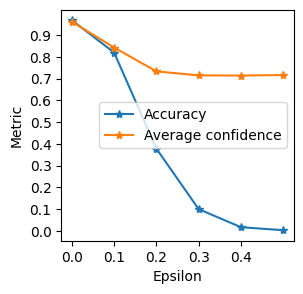

In [38]:
# Metrics
accuracy = []
average_confidence = []

for epsilon in epsilons:
    metrics = evaluate(model_a, test_loader, device, attack=FastGradient(model_b, epsilon=epsilon))

    accuracy.append(metrics['accuracy'])
    average_confidence.append(metrics['average_confidence'])

plt.figure(figsize=(3, 3))
plt.plot(epsilons, accuracy, "*-", label='Accuracy')
plt.plot(epsilons, average_confidence, "*-", label='Average confidence')
plt.yticks(np.arange(0, 1, step=0.1))
plt.xticks(np.arange(0, 0.5, step=0.1))
plt.xlabel("Epsilon")
plt.ylabel("Metric")
plt.legend()
plt.show()